# Credit EDA Case Study

### 1. Libraries and Files

We import all the relevant libraries and the two files __application_data__ and __previous_application__. Straight-up , we check the shape of our data-frames.

In [114]:
import pandas as pd
import numpy as np
import math

import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib import cm
import matplotlib.gridspec as gridspec
sns.set(style="whitegrid")

#_____________________________________________________________
# This function below helps us to print content in bold/colored
# in the Jupyter Notebook

from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))
#_____________________________________________________________

app=pd.read_csv('application_data.csv')


In [115]:
printmd('**Application Data {}**'.format(app.shape))

**Application Data (307511, 122)**

TARGET
0    282686
1     24825
Name: SK_ID_CURR, dtype: int64

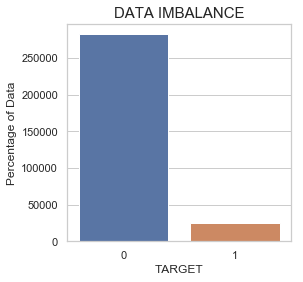

In [116]:
# Let us check the data imbalance by assessing the percentage of rows with TARGET=1 and 0
tgts=app.groupby('TARGET').count()['SK_ID_CURR']
fig1, ax = plt.subplots(figsize=(4, 4))

ax = sns.barplot(x=tgts.index, y=tgts.values, label='TARGET')
ax.set_xlabel('TARGET')
ax.set_ylabel('Percentage of Data')
ax.set_title('DATA IMBALANCE',fontsize= 15)
tgts

Out of the 307511 rows, we notice that 282686 rows are 0 and only 24825 are 1. That mean 92% cases are those customer IDs who did not have any problem making payment. Only 8% Data pertains to TARGET, which is the subject of making a predictive model.

### 2. Missing Data and Cleaning
We notice that there are 122 columns in the application data. Let us check, what's the extent of missing data in our application dataframe named __app__. The following routine , lists out all the columns that have more than 30% ( **an arbitrary choice**) of data missing column-wise.  

**Columns with more than 30% missing data**

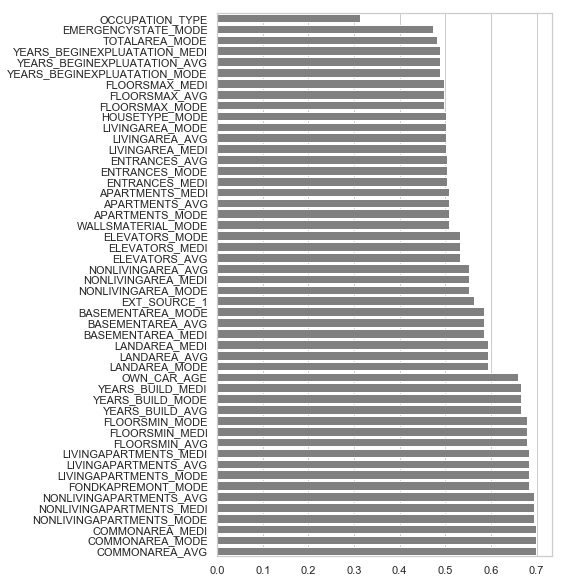

In [117]:
mis_col = app.isnull().sum() # Deduce the number of null values in all columns in the form of a series

# In the series retain only those column names which have more than 30% missing values and print it.
mis_col = mis_col[mis_col.values >(0.3*len(app))]
printmd('**Columns with more than 30% missing data**')
mis_col=mis_col.apply(lambda x:x/307511)
mis_col2=mis_col.sort_values()
fig2, ax = plt.subplots(figsize=(6, 10))
ax = sns.barplot(y=mis_col2.index, x=mis_col2.values,color='grey')

The major share of missing data seems to be related to the type of apartment the client lives in. These columns with such large number of missing values are simply not possible to impute. There is a column available __FLAG_OWN_REALTY__,indicating whether applicant owns a house or not. We will use this info and eliminate the other columns. <br> We notice that the apartment related index in the __mis_col__ series is from the 4th row. So we eliminate the columns appearing from from index 3 in __mis_col__ from the __app__ dataframe. We do this by making a copy of our dataframe __app__ and call it __app2__.

In [118]:
# Delete the columns with more than 30% missing values,pertaining to the apartment type.
app2=app.drop(mis_col.index[3:],axis=1) 

Now in __app2__,let us check how many missing values do we have ?

In [119]:
mis_col2 = app2.isnull().sum()
mis_col2 = mis_col2[mis_col2.values !=0]
mis_col2

AMT_ANNUITY                       12
AMT_GOODS_PRICE                  278
NAME_TYPE_SUITE                 1292
OWN_CAR_AGE                   202929
OCCUPATION_TYPE                96391
CNT_FAM_MEMBERS                    2
EXT_SOURCE_1                  173378
EXT_SOURCE_2                     660
EXT_SOURCE_3                   60965
OBS_30_CNT_SOCIAL_CIRCLE        1021
DEF_30_CNT_SOCIAL_CIRCLE        1021
OBS_60_CNT_SOCIAL_CIRCLE        1021
DEF_60_CNT_SOCIAL_CIRCLE        1021
DAYS_LAST_PHONE_CHANGE             1
AMT_REQ_CREDIT_BUREAU_HOUR     41519
AMT_REQ_CREDIT_BUREAU_DAY      41519
AMT_REQ_CREDIT_BUREAU_WEEK     41519
AMT_REQ_CREDIT_BUREAU_MON      41519
AMT_REQ_CREDIT_BUREAU_QRT      41519
AMT_REQ_CREDIT_BUREAU_YEAR     41519
dtype: int64

It's very interetsing to have exactly same number of missing values across multiple columns. The Columns __EXT_SOURCE_1,EXT_SOURCE_1 and EXT_SOURCE_1__ can be averaged across the row, if they are simulataneoulsy __NaN__. Below, we check how many rows are there , where all 3 are Nan

In [120]:
# How many rows are there, where all these 3 columns are set to NaN
app2[app2['EXT_SOURCE_1'].isna() & app2['EXT_SOURCE_2'].isna() & app2['EXT_SOURCE_3'].isna()].shape

(172, 75)

That's not too many, considering we have 307K rows worth of data. We can prepare a new derived metric __SCORE__ which is average of the 3 sources and safely delete these three columns.

In [121]:
# Remove rows where all EXT_SOURCE are NAN
app2=app2[~(app2['EXT_SOURCE_1'].isna() & app2['EXT_SOURCE_2'].isna() & app2['EXT_SOURCE_3'].isna())]

# Make a new column SCORE , which is average of all three EXT_SOURCE 1/2/3
app2['SCORE']=app2[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)

# Now delete the EXT_SOURCE columns, as we have a SCORE column
app2=app2.drop(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3'],axis=1) 

Next we deal with columns __AMT_ANNUITY__ , __AMT_REQ_CREDIT__ and __CNT_SOCIAL_CIRCLE__.<br>

>1 __AMT_REQ_CREDIT__ provide number of queries in the last one hour to 1 year.<br> 
>2 __CNT_SOCIAL_CIRCLE__ has 4 separate columns about there's an observable 30/60 DPD Default or there was indeed a default past 30/60 days.<br>
>3 __AMT_ANNUITY__ cannot possibly be 0, so we cannot replace missing values with 0, instead we delete them.<br>
>4 __AMT_GOODS_PRICE__ we shall fill with the mean of the column

In both cases, we can simply replace with zeroes, meaning no queries registered and no defaults observed.<br>

In [122]:
# A List comprehension to generate column names with AMT_REQ_CREDIT or CNT_SOCIAL_CIRCLE, so that we can replace
# them with zeros.

query_cols=[i for i in app2.columns if i.find('AMT_REQ_CREDIT')>-1 or i.find('CNT_SOCIAL_CIRCLE')>-1]
app2[query_cols]=app2[query_cols].fillna(0)

app2=app2[~app2['AMT_ANNUITY'].isna()]
app2['CNT_FAM_MEMBERS']=app2['CNT_FAM_MEMBERS'].fillna(1)
app2['AMT_GOODS_PRICE']=app2['AMT_GOODS_PRICE'].fillna(app2['AMT_GOODS_PRICE'].mean())

>1 The __CODE_GENDER__ column has has only 4 entries set to XNA, so we can delete them<br>
>2 Remove the missing values for __NAME_TYPE_SUITE__ with Unaccompanied<br>
>3 The Organization type has 59 variables, we reduce it to 18 types <br>
>4 The __INCOME_TYPE__ variable is reduced to only 4 type.

In [123]:
# Delete all rows with CODE_GENDER set to XNA
app2=app2[app2['CODE_GENDER']!='XNA']

# Remove Missing Values from OCCUPATION_TYPE and NAME_TYPE_SUITE 

app2.fillna({'NAME_TYPE_SUITE':'Unaccompanied'},inplace=True)

# Replace the different Industry,Business, Transport and Tradetype with one respective value. 

app2['ORGANIZATION_TYPE']=app2['ORGANIZATION_TYPE'].apply(lambda x:'Industry' if x.find('Industry:')>-1 else x)
app2['ORGANIZATION_TYPE']=app2['ORGANIZATION_TYPE'].apply(lambda x:'Transport' if x.find('Transport:')>-1 else x)
app2['ORGANIZATION_TYPE']=app2['ORGANIZATION_TYPE'].apply(lambda x:'Trade' if x.find('Trade:')>-1 else x)
app2['ORGANIZATION_TYPE']=app2['ORGANIZATION_TYPE'].apply(lambda x:'Business' if x.find('Business Entity Type')>-1 else x)

# Now we can classify the Organization type to only few classes.

org_type=app2['ORGANIZATION_TYPE'].unique()
org_type2=['Business','Edu','Govt','Religion','Other','XNA','Utility', 'Core','Self','Transport','Core','Core','Edu',
           'Trade','Industry', 'Military','Services','Govt','Utility','Services','Edu','Police', 'Services','Core','Services',
           'Culture','Services','Services','Industry', 'Services','Services','Services','Services','Services','Realtor']

app2['ORGANIZATION_TYPE'].replace(org_type,org_type2,inplace=True)

# The list inc_type having 8 unique values is reduced to 4.

inc_type=['Working', 'State servant', 'Commercial associate', 'Pensioner',
       'Unemployed', 'Student', 'Businessman', 'Maternity leave']
inc_type2=['Working', 'Working', 'Working', 'Pensioner',
       'Unemployed', 'Student','Working', 'Working']

app2['NAME_INCOME_TYPE'].replace(inc_type,inc_type2,inplace=True)

The __OCCUPATION_TYPE__ column has 96000 missing values, We Replace the all the missing occupation types with DNA ( Data Not Available ).

The __ORGANIZATION_TYPE__ column has 58 values, but we can reduce them to 17.

In [124]:
# The list occ_type is converted White Collar and Blue Collar jobs.

app2.fillna({'OCCUPATION_TYPE':'DNA'},inplace=True)
occ_type=['Accountants','Cleaning staff','Cooking staff',
          'Core staff','Drivers','High skill tech staff','HR staff',
          'IT staff','Laborers','Low-skill Laborers','Managers','Medicine staff',
          'Private service staff','Realty agents','Sales staff','Secretaries',
          'Security staff','Waiters/barmen staff']
occ_type2=['WHC','BLC','BLC','WHC','BLC','WHC','WHC','WHC',
          'BLC','BLC','WHC','WHC','BLC','WHC','WHC','WHC','BLC','BLC']

app2['OCCUPATION_TYPE'].replace(occ_type,occ_type2,inplace=True)

app2['ORGANIZATION_TYPE']=app2['ORGANIZATION_TYPE'].apply(lambda x:'Industry' if x.find('Industry')>-1 else x)
app2['ORGANIZATION_TYPE']=app2['ORGANIZATION_TYPE'].apply(lambda x:'Business' if x.find('Business Entity')>-1 else x)
app2['ORGANIZATION_TYPE']=app2['ORGANIZATION_TYPE'].apply(lambda x:'Trade' if x.find('Trade')>-1 else x)
app2['ORGANIZATION_TYPE']=app2['ORGANIZATION_TYPE'].apply(lambda x:'Transport' if x.find('Transport')>-1 else x)

org_type1=['Advertising','Agriculture','Bank','Business','Cleaning','Construction','Culture',
'Electricity','Emergency','Government','Hotel','Housing','Industry','Insurance',
'Kindergarten','Legal Services','Medicine','Military','Mobile','Other','Police','Postal',
'Realtor','Religion','Restaurant','School','Security','Security Ministries','Self-employed',
'Services','Telecom','Trade','Transport','University']

org_type2=['Services','Core','Services','Business','Services','Core','Culture','Utility','Utility','Govt',
'Services','Core','Industry','Services','Edu','Services','Core','Military','Services','Other',
'Police','Services','Realtor','Religion','Services','Edu','Services','Govt','Self','Services',
'Services','Trade','Transport','Edu']

app2['ORGANIZATION_TYPE'].replace(org_type1,org_type2,inplace=True)


In [125]:
mis_col2 = app2.isnull().sum()
mis_col2 = mis_col2[mis_col2.values !=0]
mis_col2

OWN_CAR_AGE    202790
dtype: int64

In [126]:
app2[(app2['FLAG_OWN_CAR']=='N') & (app2['OWN_CAR_AGE'].isna())].shape

(202785, 73)

### 3. Outliers 

Before proceeding further, we will get rid of the outliers that may unnecessarily ruin our observations later.

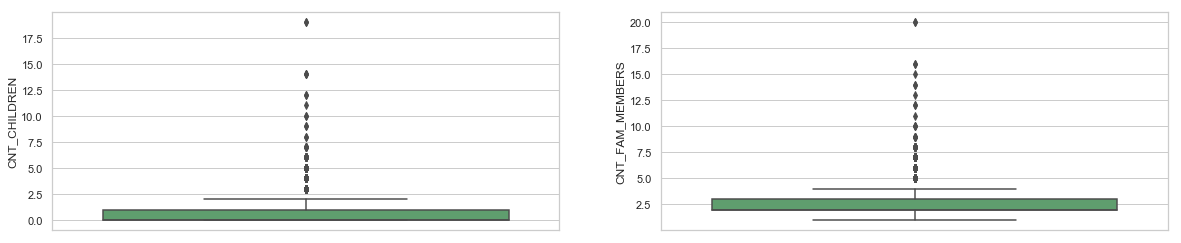

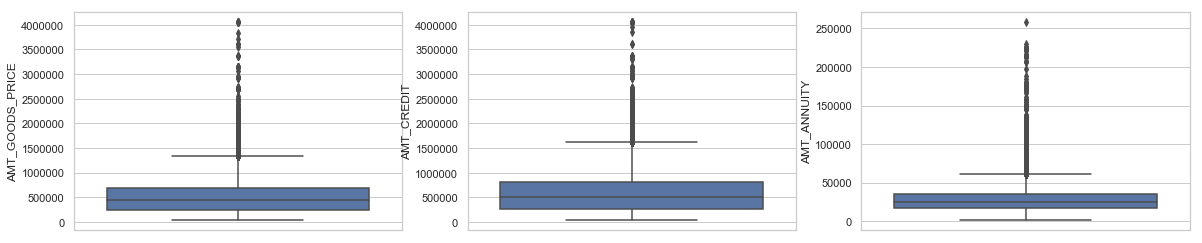

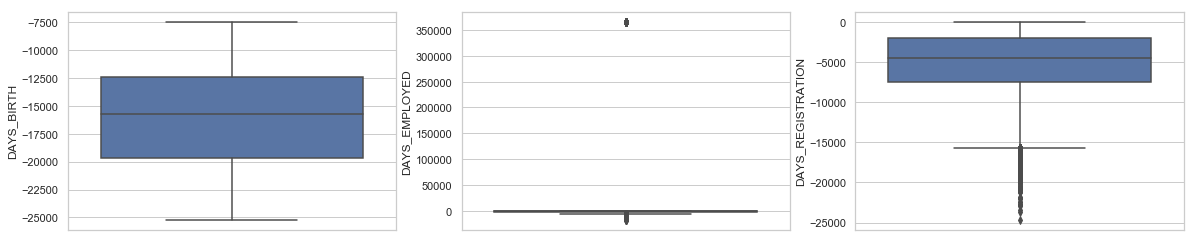

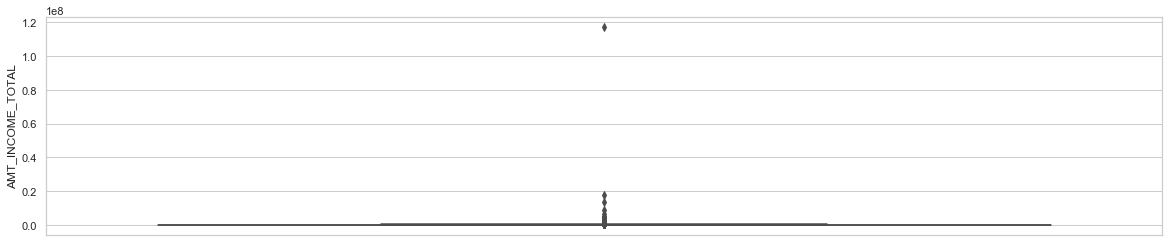

In [127]:
detect_outlier=['CNT_CHILDREN','CNT_FAM_MEMBERS','AMT_INCOME_TOTAL','AMT_CREDIT','AMT_ANNUITY','AMT_GOODS_PRICE',
                'DAYS_BIRTH','DAYS_EMPLOYED','DAYS_REGISTRATION','DAYS_ID_PUBLISH','OWN_CAR_AGE']

fig3a, (ax1, ax2) = plt.subplots(1,2,figsize=(20, 4))
sns.boxplot(y='CNT_CHILDREN',data=app2,ax=ax1,color='g')
sns.boxplot(y='CNT_FAM_MEMBERS',data=app2,ax=ax2,color='g')


fig3b, (ax1, ax2,ax3) = plt.subplots(1,3,figsize=(20, 4))
sns.boxplot(y='AMT_GOODS_PRICE',data=app2,ax=ax1)
sns.boxplot(y='AMT_CREDIT',data=app2,ax=ax2)
sns.boxplot(y='AMT_ANNUITY',data=app2,ax=ax3)

fig3c, (ax1, ax2,ax3) = plt.subplots(1,3,figsize=(20, 4))
sns.boxplot(y='DAYS_BIRTH',data=app2,ax=ax1)
sns.boxplot(y='DAYS_EMPLOYED',data=app2,ax=ax2)
sns.boxplot(y='DAYS_REGISTRATION',data=app2,ax=ax3)

fig3d, ax = plt.subplots(1,1,figsize=(20, 4))
sns.boxplot(y='AMT_INCOME_TOTAL',data=app2,ax=ax)


These continuous variables are severely polluted by outliers. We will remove rows above the 95th percentile and plot them again.

In [128]:
p1=app2['DAYS_EMPLOYED'].quantile(0.95)
p2=app2['CNT_FAM_MEMBERS'].quantile(0.95)
p3=app2['CNT_CHILDREN'].quantile(0.95)
p4=app2['AMT_INCOME_TOTAL'].quantile(0.95)
p5=app2['OWN_CAR_AGE'].quantile(0.95)

app2=app2[app2['DAYS_EMPLOYED']<p1]
app2=app2[app2['CNT_FAM_MEMBERS']<p2]
app2=app2[app2['CNT_CHILDREN']<p3]
app2=app2[app2['AMT_INCOME_TOTAL']<p4]
app2=app2[app2['OWN_CAR_AGE']<p5]

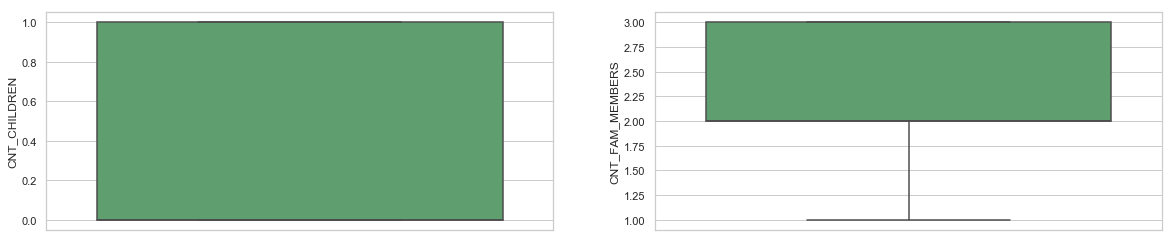

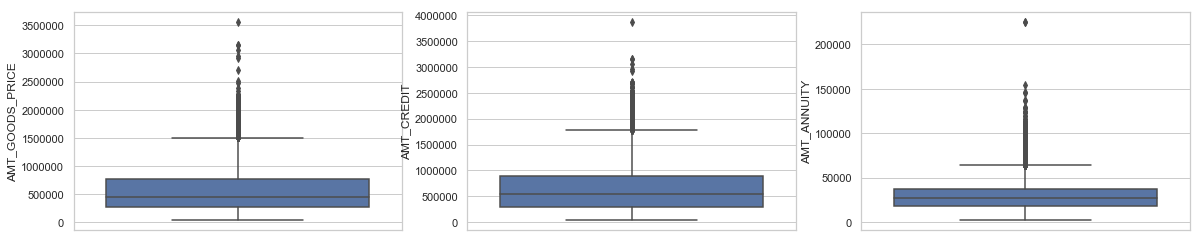

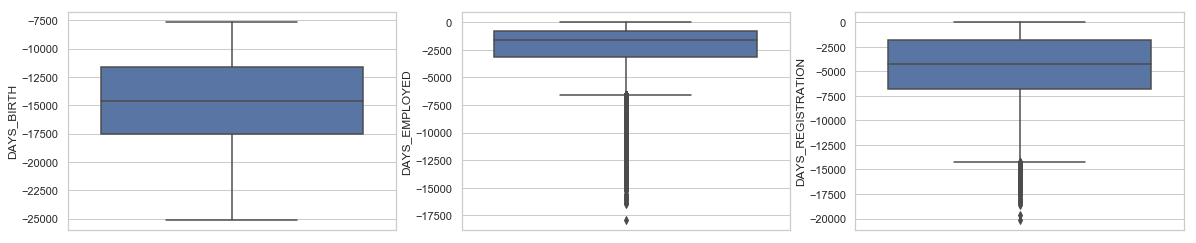

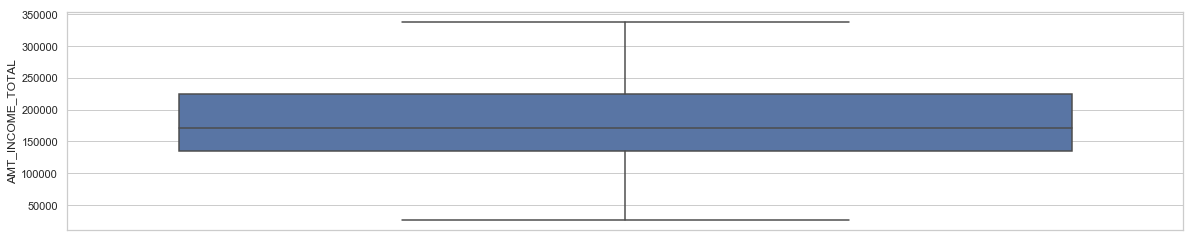

In [129]:

fig3e, (ax1, ax2) = plt.subplots(1,2,figsize=(20, 4))
sns.boxplot(y='CNT_CHILDREN',data=app2,ax=ax1,color='g')
sns.boxplot(y='CNT_FAM_MEMBERS',data=app2,ax=ax2,color='g')


fig3f, (ax1, ax2,ax3) = plt.subplots(1,3,figsize=(20, 4))
sns.boxplot(y='AMT_GOODS_PRICE',data=app2,ax=ax1)
sns.boxplot(y='AMT_CREDIT',data=app2,ax=ax2)
sns.boxplot(y='AMT_ANNUITY',data=app2,ax=ax3)

fig3g, (ax1, ax2,ax3) = plt.subplots(1,3,figsize=(20, 4))
sns.boxplot(y='DAYS_BIRTH',data=app2,ax=ax1)
sns.boxplot(y='DAYS_EMPLOYED',data=app2,ax=ax2)
sns.boxplot(y='DAYS_REGISTRATION',data=app2,ax=ax3)

fig3h, ax = plt.subplots(1,1,figsize=(20, 4))
sns.boxplot(y='AMT_INCOME_TOTAL',data=app2,ax=ax)


Much better !!! These removal of outliers , will result in better correlation calculation.

### 4. Univariate Analysis

Now  that , we've gotten rid of most of the missing values and have generated some derived metrics, we can now perform univariate analysis.

#### 4.1 Segmented Univariate Analysis

We start with visualizing some of the binary categorical variables followed by a  . We define a function to draw count-plots, so that we can call it repetetively.

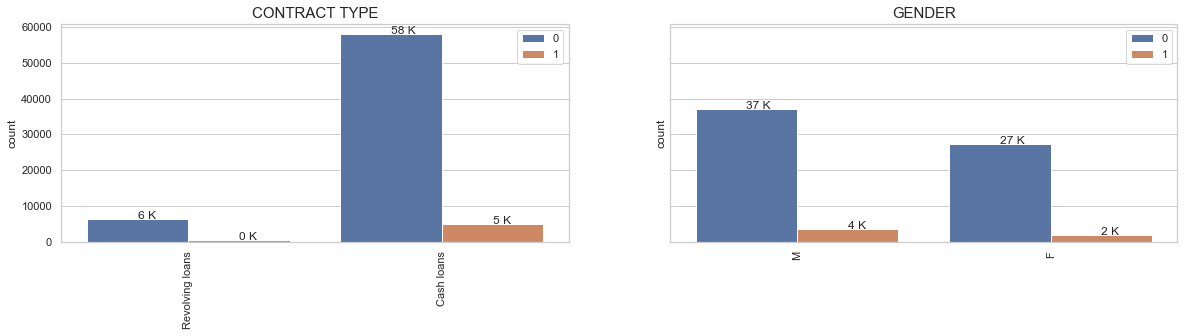

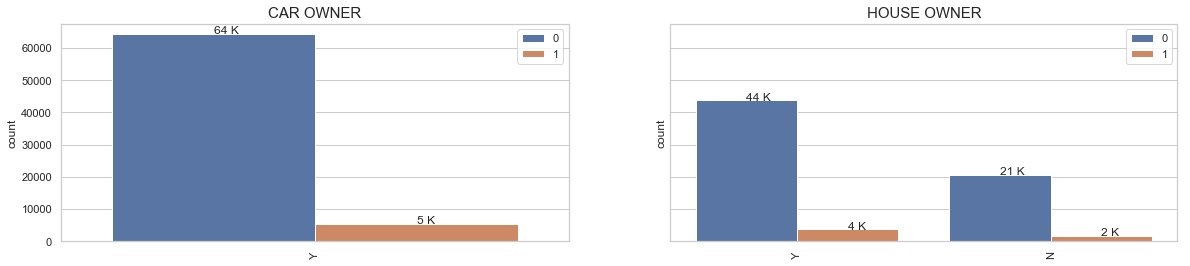

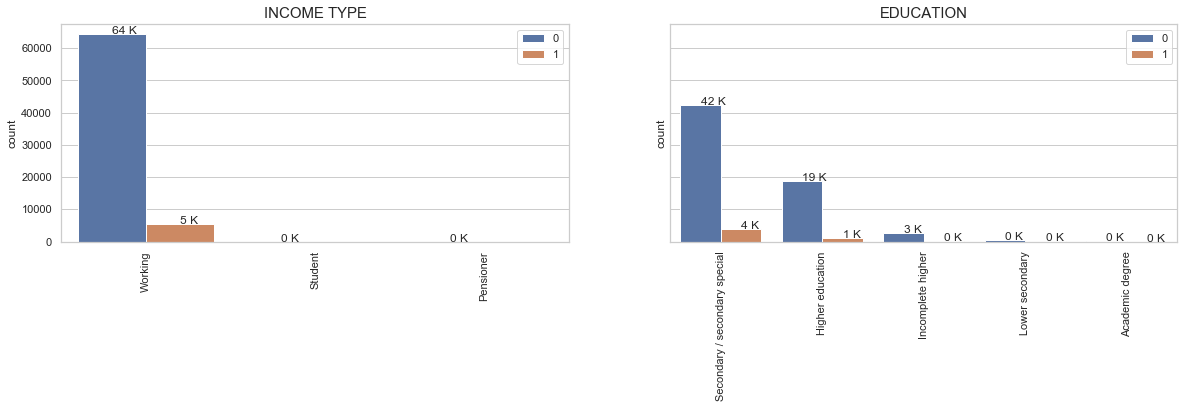

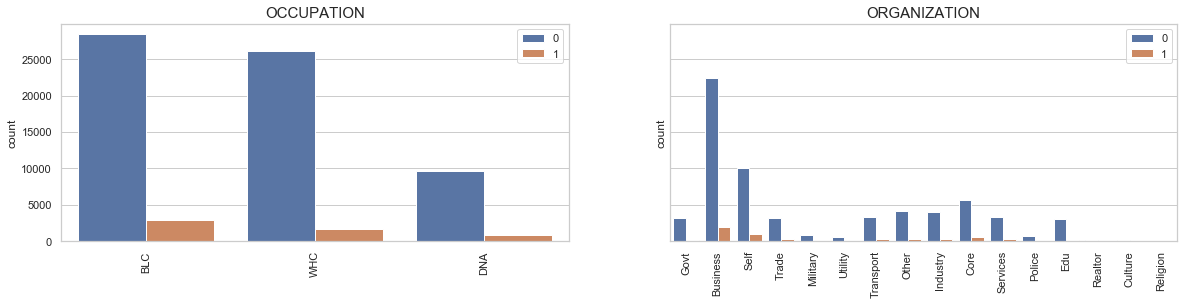

In [130]:
def plot_categorical(ax,x_axis,target,df,annot=True,hdr=''):
    
    my_plot = sns.countplot(x=x_axis, hue="TARGET", data=df,ax=ax)
    for p in ax.patches:
        if math.isnan(p.get_height())==False and annot==True:
            ax.annotate('{:1.0f} K'.format((p.get_height())/1000), (p.get_x()+p.get_width()/2, p.get_height()+20))
    
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)
    ax.legend(loc='upper right', frameon=True)
    ax.set_xlabel('')
    ax.set_title(hdr,fontsize= 15)
        
    return my_plot

fig4a, (ax1, ax2) = plt.subplots(1,2,figsize=(20, 4),sharey=True)
plot_categorical(ax1,"NAME_CONTRACT_TYPE","TARGET",app2,True,'CONTRACT TYPE')
plot_categorical(ax2,"CODE_GENDER","TARGET",app2,True,'GENDER')

fig4b, (ax1, ax2) = plt.subplots(1,2,figsize=(20, 4),sharey=True)
plot_categorical(ax1,"FLAG_OWN_CAR","TARGET",app2,True,'CAR OWNER')
plot_categorical(ax2,"FLAG_OWN_REALTY","TARGET",app2,True,'HOUSE OWNER')

fig4c, (ax1, ax2) = plt.subplots(1,2,figsize=(20, 4),sharey=True)
plot_categorical(ax1,"NAME_INCOME_TYPE","TARGET",app2,True,'INCOME TYPE')
plot_categorical(ax2,"NAME_EDUCATION_TYPE","TARGET",app2,True,'EDUCATION')

fig4d, (ax1, ax2) = plt.subplots(1,2,figsize=(20, 4),sharey=True)
plot_categorical(ax1,"OCCUPATION_TYPE","TARGET",app2,False,'OCCUPATION')
plot_categorical(ax2,"ORGANIZATION_TYPE","TARGET",app2,False,'ORGANIZATION')

__Segmented Univariate Observations__

1) Cash Loans are more likely than Revolving Loans.<br>
2) Probability of an applicant being female is almost twice as much as that of male.<br>
3) Real Estate and Non Car owners are more likely to apply for loans.<br>
4) Among the income types Working Class constitute the largest number of applicants.<br>
5) Among the applicants, the educated class forms the largest components. 

__Data Imbalance__

1) Cash Loans are way more numerous than Revolving loans.<br>
2) The primary Loan applicant is more likely to be Female.<br>
3) Among the __Income-Type__ , Unemployed and Students are practically 0 compared to Working and Pensioners.<br>
4) Among the education category , Secondary and Higher Education are most neumerous.<br>
5) Organization type Military, Police, Religion, Culture and Realtor are not prominent applicants.<br>


### 5. Bivariate Categorical Variable Analysis
In this section, we establish the relationship of the categorical variables with the target variables, by running a __Chi-square__ Test of independence using scipy.chi2_contingency.<br>
However, for this to work, we need to first figure out the categorical variables from the continuous ones.<br> We filter out all binary columns into __binary_vals__ and run a chi-square test for each of them with the __TARGET__ with a alpha significance level of 0.05.<br> We retain only those variables, which result in a p-values < 0.05.

>1 Filter out all variables which have only 2 unique values into __binary_vars__ <br>
>2 We then add the remaining categorical variables manually. <br> 
>2 Generate a crosstab with every individual variable and __TARGET__<br>
>3 Pass the crosstab to a chi2_contingency test. <br>
>4 Retain variables with p-value< 0.05 and pss them to temporary lists<br>
>5 Make a dataframe called __sig_vars__ , meaning significant variables, form the temporary lists .<br>

__Very Important: Since the p-vals are very small, we take a base 10 logarithm and retain there absolute values.__

In [131]:
# This filters out all the columns which have binary values.
cat_vars=[i for i in app2.columns if app2[i].nunique()==2]

# We need to append the remaining categorical values manually.

rem_cats=['NAME_TYPE_SUITE','NAME_INCOME_TYPE','NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS','NAME_HOUSING_TYPE',
'OCCUPATION_TYPE','ORGANIZATION_TYPE','FLAG_DOCUMENT_21']

cat_vars=cat_vars+rem_cats

In [132]:
from scipy import stats
from math import exp, expm1

temp_list=[]

for i in cat_vars:
    crosstab=pd.crosstab(app2['TARGET'],app2[i])
    p_val=stats.chi2_contingency(crosstab)[1]
    if p_val<0.05 and p_val!=0:
        temp_list.append((i,abs(round(math.log10(p_val),2))))

sig_vars=pd.DataFrame(temp_list,columns=('VARIABLE','ABS_LOG10_PVAL'))        

Text(0.5, 1.0, 'Absolute Values of 10log(P_Val) Chi2 Test')

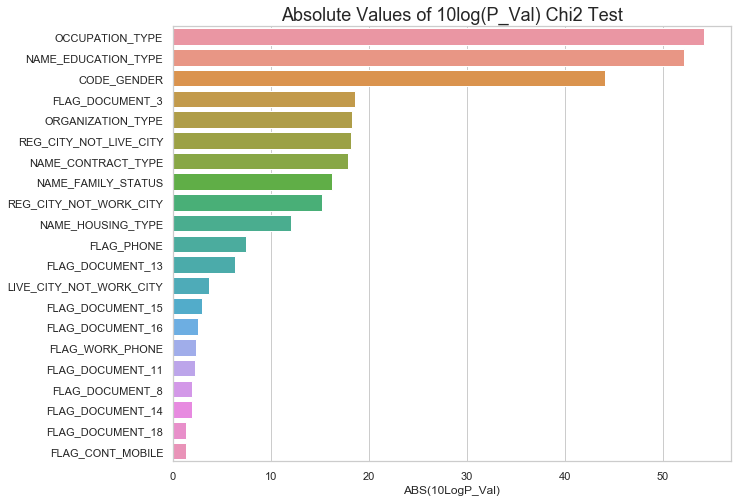

In [133]:
sns.set(style="whitegrid")
sig_vars.sort_values(by='ABS_LOG10_PVAL',ascending=False,inplace=True)

fig5, ax = plt.subplots(figsize=(10, 8))
ax = sns.barplot(x='ABS_LOG10_PVAL', y='VARIABLE', data=sig_vars)

ax.set(ylabel="",xlabel="ABS(10LogP_Val)")
ax.set_title('Absolute Values of 10log(P_Val) Chi2 Test',fontsize= 18)

### 6. Bivariate Continuous Variable Analysis

We begin by calculating which variables did we not include in the list of categorical columns __binary_vars__. The remaining Columns must be the continuous ones.

In [134]:
# This gives us all columns which weren't part of the Chi2 Analysis above.
# We remove FLAG_MOBIL as it has only one row with 0 and remaining all are 1.
# We Remove SK_ID_CURR as this is not a parameter of interest.
# We append TARGET to this list.
# We also remove the CNT_SOCIAL and AMT_REQ_CREDIT

cont_cols=[i for i in app2.columns if i not in  cat_vars]
cont_cols.append('TARGET')
cont_cols.remove('FLAG_MOBIL')
cont_cols.remove('SK_ID_CURR')
cont_cols=[i for i in cont_cols if i.find('CNT_SOCIAL')==-1 and i.find('AMT_REQ_CREDIT')==-1]

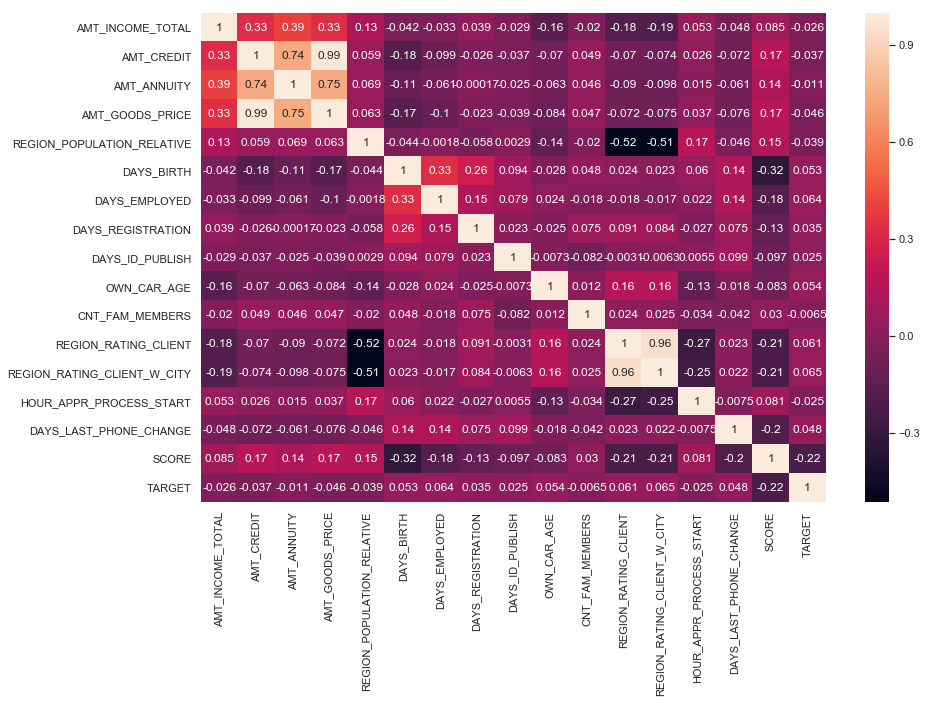

In [135]:
loan_correlation = app2[cont_cols].corr()
fig6, ax = plt.subplots(figsize=(14, 9))
sns.heatmap(loan_correlation, 
            xticklabels=loan_correlation.columns.values,
            yticklabels=loan_correlation.columns.values,annot= True)
plt.show()

To find the strongest Continuous Variables , we need to consider the absolute values of the correlation coefficient for the TARGET

In [136]:
loan_corr=loan_correlation['TARGET']

In [137]:
loan_corr=loan_corr.apply(lambda x: abs(x))
loan_corr=loan_corr.sort_values(ascending=False)
loan_corr

TARGET                         1.000000
SCORE                          0.215244
REGION_RATING_CLIENT_W_CITY    0.064522
DAYS_EMPLOYED                  0.064494
REGION_RATING_CLIENT           0.061374
OWN_CAR_AGE                    0.053798
DAYS_BIRTH                     0.053346
DAYS_LAST_PHONE_CHANGE         0.048497
AMT_GOODS_PRICE                0.046269
REGION_POPULATION_RELATIVE     0.038806
AMT_CREDIT                     0.037318
DAYS_REGISTRATION              0.034972
AMT_INCOME_TOTAL               0.026275
DAYS_ID_PUBLISH                0.025419
HOUR_APPR_PROCESS_START        0.024653
AMT_ANNUITY                    0.010678
CNT_FAM_MEMBERS                0.006476
Name: TARGET, dtype: float64

### 7. Bivariate Continuous vs Categorical Variable Analysis

We now have the top Categorical Variables in __cat__ and continuous in __cons__. We need to establish, if there is any significant relation among the individual Categorical and Contiuous variables. As an example , we plot the distribution of __AMT_CREDIT__ for various __OCCUPATION_TYPE__.<br>

However, instead of plotting them individually , we perform a one way ANOVA for each of the individual pair of Categorical and Contiuous variables.

In [141]:
cons=list(loan_corr[1:11].index)
# We remove OWN_CAR_AGE , as the variable FLAG_OWN_CAR did not appear as the top categorical variable. 
# Besides, it has 200K missing entries.
cons=[i for i in cons if i!='OWN_CAR_AGE']
cat=list(sig_vars.iloc[0:10:,::]['VARIABLE'])

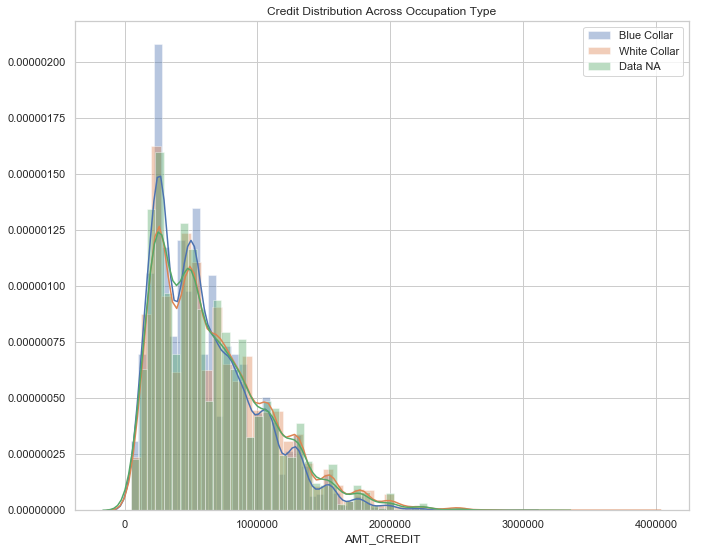

In [142]:
fig7, ax = plt.subplots(figsize=(11,9))

sns.distplot(app2[app2.OCCUPATION_TYPE == 'BLC'].AMT_CREDIT, ax=ax, label='Blue Collar')
sns.distplot(app2[app2.OCCUPATION_TYPE == 'WHC'].AMT_CREDIT, ax=ax, label='White Collar')
sns.distplot(app2[app2.OCCUPATION_TYPE == 'DNA'].AMT_CREDIT, ax=ax, label='Data NA')
plt.title('Credit Distribution Across Occupation Type')
plt.legend()


In [143]:
correlation=[]
for i in cat: # Loop through a list of Categoricals
    for j in cons: # Loop through a list of Continuous Variables
        result=app2.groupby(i)[j].apply(list)
        F, p = stats.f_oneway(*result)
        correlation.append((i,j,p))

correlation_df=pd.DataFrame(correlation,columns=('CATEGORICAL','CONTINUOUS','P_VAL'))
correlation_pv=correlation_df.pivot(index='CATEGORICAL',columns='CONTINUOUS',values='P_VAL')

We are now having the __p_vals__ for various combination of the Categorical and Continuous variables. For each pair, we have a null hypothesis that for different segments of a categorical variable, there’s no difference in the means of the continuous variables. 

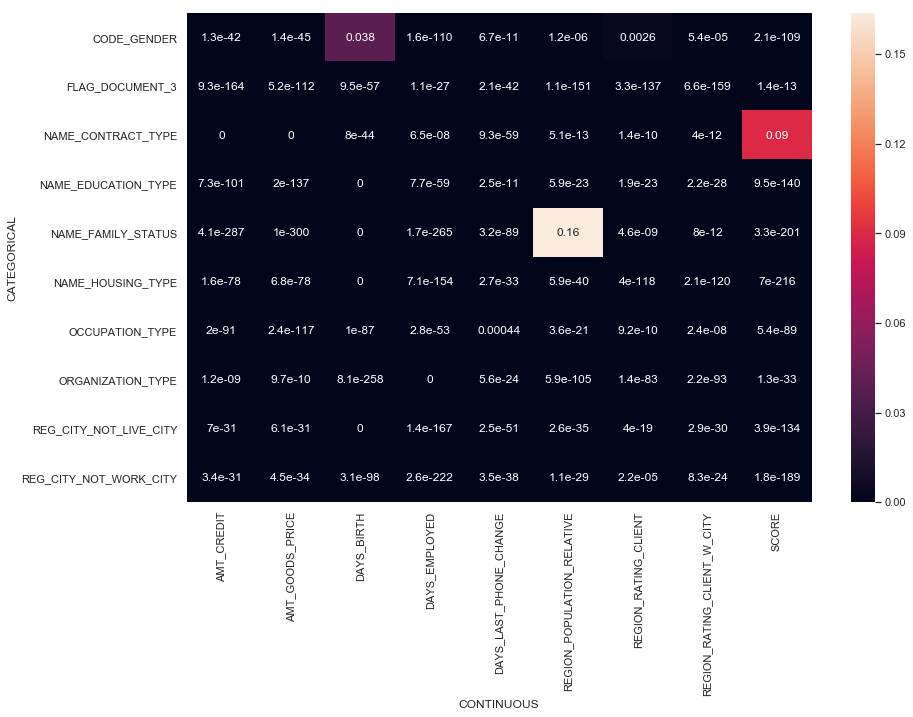

**In the Heatmap, p_vals<0.05 indicates H0 cannot be rejected**

In [144]:
fig8, ax = plt.subplots(figsize=(14, 9))
sns.heatmap(correlation_pv, 
            xticklabels=correlation_pv.columns.values,
            yticklabels=correlation_pv.index,annot= True)
plt.show()
printmd('**In the Heatmap, p_vals<0.05 indicates H0 cannot be rejected**')

### 8. Establish Correlation with Previous Applications

We first try to answer some basic questions.

>1. What is the major reason for Cash Loan<br>
>2. What constitutes the key reason for rejection<br>
>3. What is teh predominant __CONTRACT TYPE__

However, before we plot the, we will reduce the __NAME_CASH_LOAN_PURPOSE__ to types

In [145]:
prv=pd.read_csv('previous_application.csv')

In [146]:
loan_purpose=['Refusal to name the goal', 'Money for a third person', 'Hobby','Buying a garage',
              'Gasification / water supply','Business development','Buying a holiday home / land','Furniture',
              'Car repairs', 'Buying a home', 'Wedding / gift / holiday','Buying a new car',
              'Purchase of electronic equipment', 'Journey','Education', 'Payments on other loans',
              'Medicine', 'Everyday expenses','Building a house or an annex', 'Buying a used car',
              'Urgent needs','Other', 'Repairs', 'XNA', 'XAP']

repl_with=['Build','Business','Build','Home','Home','Car','Car','Repair','Education',
           'Other','Other','Other','Entmnt','Travel','Medicine','Other','Other','Other',
           'Other','XNA','Repair','Other','Entmnt','XAP','XNA']

prv['NAME_CASH_LOAN_PURPOSE'].replace(loan_purpose,repl_with,inplace=True)

In [147]:
purpose=prv.groupby('NAME_CASH_LOAN_PURPOSE').count()['SK_ID_CURR'].sort_values()
rejects=prv.groupby('CODE_REJECT_REASON').count()['SK_ID_CURR'].sort_values(ascending=False)
cont_type=prv.groupby('NAME_CONTRACT_TYPE').count()['SK_ID_CURR'].sort_values()

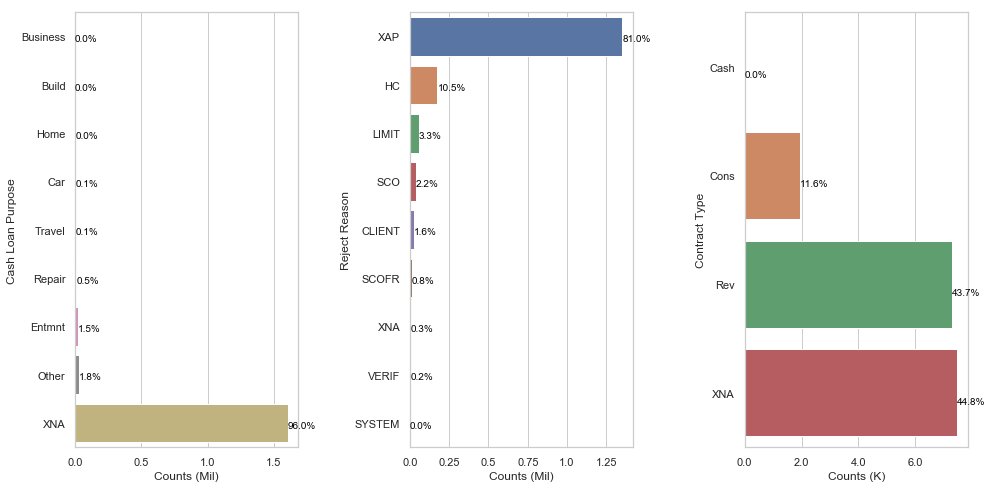

In [148]:
fig9, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(16, 8))
fig9.subplots_adjust(wspace=.5)

sns.barplot(y=purpose.index, x=purpose.values,ax=ax1)
ax1.set_xticklabels(np.linspace(0,1.5,4))
ax1.set_xlabel('Counts (Mil)')
ax1.set_ylabel('Cash Loan Purpose')
for i in ax1.patches:
    ax1.text(i.get_width(), i.get_y()+.5,str(round(100*i.get_width()/purpose.sum(), 1))+'%', fontsize=10,color='black')

sns.barplot(y=rejects.index, x=rejects.values,ax=ax2)
ax2.set_xticklabels(np.linspace(0,1.25,6))
ax2.set_xlabel('Counts (Mil)')
ax2.set_ylabel('Reject Reason')
for i in ax2.patches:
    ax2.text(i.get_width(), i.get_y()+.5,str(round(100*i.get_width()/rejects.sum(), 1))+'%', fontsize=10,color='black')


sns.barplot(y=cont_type.index, x=cont_type.values,ax=ax3)
ax3.set_xticklabels(np.linspace(0,6,4))
ax3.set_yticklabels(['Cash','Cons','Rev','XNA'])
ax3.set_xlabel('Counts (K)')
ax3.set_ylabel('Contract Type')
for i in ax3.patches:
    ax3.text(i.get_width(), i.get_y()+.5,str(round(100*i.get_width()/cont_type.sum(), 1))+'%', fontsize=10,color='black')

The __NAME_CASH_LOAN_PURPOSE__ is pretty useless, as close to 1.5M rows of data have XNA. So we might as well delete it.<br> Due to the same reason __NAME_GOODS_CATEGORY__ is also useless, because 96% data is either XNA or XAP.

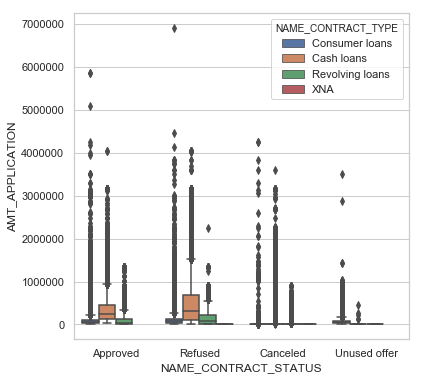

In [152]:
prv2=prv.drop(['NAME_CASH_LOAN_PURPOSE','NAME_GOODS_CATEGORY'],axis=1)
plt.figure(figsize=(6,6))
sns.boxplot(data =prv2, x='NAME_CONTRACT_STATUS', y='AMT_APPLICATION', hue ='NAME_CONTRACT_TYPE')
#plt.title('Purpose of Loan vs Loan Amount')
plt.show()

Let us propose a null hypothesis , that the means of the Application amount is same irrespective of the application outcome.

In [153]:
result=prv2.groupby('NAME_CONTRACT_STATUS')['AMT_APPLICATION'].apply(list)
F, p = stats.f_oneway(*result)
p

0.0

We can reject the null hypothesis proposed above. Similarly , for the following categorical variables we run a Chi2 Contingency test, to see if they have any impact on the Application Outcome.

In [154]:
# This is our List of Categorical Variable
cat_vars=['NAME_CONTRACT_TYPE', 'NAME_PAYMENT_TYPE','NAME_CLIENT_TYPE','NAME_PORTFOLIO','NAME_PRODUCT_TYPE','CHANNEL_TYPE',
 'SELLERPLACE_AREA','NAME_YIELD_GROUP']

In [155]:
# We prepare a dataframe my_vars containing the p_values for their Chi2 test with NAME_CONTRACT_STATUS
temp_list=[]

for i in cat_vars:
    crosstab=pd.crosstab(prv2['NAME_CONTRACT_STATUS'],prv2[i])
    p_val=stats.chi2_contingency(crosstab)[1]
    if p_val<0.05:
        temp_list.append((i,p_val))

my_vars=pd.DataFrame(temp_list,columns=('VARIABLE','P_VAL'))

In [156]:
my_vars

,VARIABLE,P_VAL
0,NAME_CONTRACT_TYPE,0.0
1,NAME_PAYMENT_TYPE,0.0
2,NAME_CLIENT_TYPE,0.0
3,NAME_PORTFOLIO,0.0
4,NAME_PRODUCT_TYPE,0.0
5,CHANNEL_TYPE,0.0
6,SELLERPLACE_AREA,0.0
7,NAME_YIELD_GROUP,0.0


All the 8 variables have correlation with the application outcome.